In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Simulate the Response Curves

The following constructs synthetic profiles to simplify debugging:

In [2]:
def synth_curves(alpha=10, beta=100, theta=10):
    thr = lambda bs: np.log(bs*theta + beta) * alpha
    return {"thr": thr, "lat": lambda bs: bs / thr(bs)}

dev_costs = {"volta": 8, "k80": 5, "cpu": 2}

In [3]:
model_info = {
    "res": {
        "volta": synth_curves(alpha=15, beta=1, theta=0.5),
        "k80": synth_curves(alpha=7, beta=1, theta=0.5),
        "cpu": synth_curves(alpha=2, beta=1, theta=0.5)
    },
    "inc": { 
        "volta": synth_curves(alpha=5, beta=10, theta=1),
        "k80": synth_curves(alpha=4, beta=10, theta=1),
        "cpu": synth_curves(alpha=3, beta=10, theta=1)
    }
}

Text(0.5,0,u'batch size')

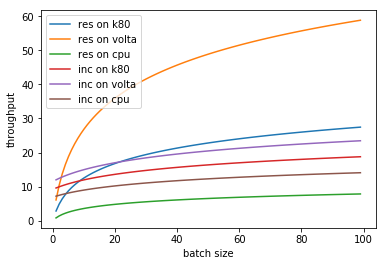

In [4]:
bs = np.arange(1,100)
for m in model_info:
    for dev in model_info[m]:
        plt.plot(bs, model_info[m][dev]['thr'](bs), label = m + " on " + dev)
plt.legend()
plt.ylabel("throughput")
plt.xlabel("batch size")

Text(0.5,0,u'batch size')

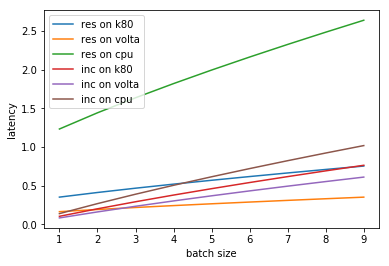

In [5]:
bs = np.arange(1,10)
for m in model_info:
    for dev in model_info[m]:
        plt.plot(bs, model_info[m][dev]['lat'](bs), label = m + " on " + dev)
plt.legend()
plt.ylabel("latency")
plt.xlabel("batch size")

# Simulate linear Pipeline of models

## Estimate performance of a configuration

The following toy function computes the performance of a pipeline of models.

In [6]:
def estimate_perf(config):
    thr = []
    lat = []
    cost = 0
    for m in config:
        dev = config[m]['dev']
        bs = config[m]['bs']
        rep = config[m]['rep']
        thr.append(model_info[m][dev]['thr'](bs) * rep )
        lat.append(model_info[m][dev]['lat'](bs) )
        cost += dev_costs[dev] * rep
    queue_time = 0.001
    return {'thr': min(thr), 'lat': sum(lat) + queue_time*len(config), 'cost': cost}

In [7]:
def satisfies_goal(config, thr_goal, lat_goal):
    perf = estimate_perf(config)
    return (perf['thr'] >= thr_goal) and (perf['lat'] <= lat_goal)

## Initialization Function

This function must construct a valid config.

In [8]:
def initialize_config(thr_goal, lat_goal):
    config = {m: {"bs": 1, "rep": 1, "dev": 'volta'} for m in model_info}
    assert estimate_perf(config)['lat'] <= lat_goal
    for m in config:
        while estimate_perf({m: config[m]})['thr'] < thr_goal:
            config[m]['rep'] += 1
    assert estimate_perf(config)['lat'] <= lat_goal
    assert estimate_perf(config)['thr'] >= thr_goal
    assert satisfies_goal(config, thr_goal, lat_goal)
    return config

In [9]:
thr_goal = 1000
lat_goal = 0.5
config = initialize_config(thr_goal, lat_goal)
print(config)
print(estimate_perf(config))

{'res': {'rep': 165, 'dev': 'volta', 'bs': 1}, 'inc': {'rep': 84, 'dev': 'volta', 'bs': 1}}
{'lat': 0.2498267091099447, 'cost': 1992, 'thr': 1003.5261425677069}


In [10]:
def minimize_cost(config, thr_goal, lat_goal):
    config = copy.deepcopy(config)
    changing = True
    while(changing):
        changing = False
        for m in config:
            # Try to increase the batch size
            config[m]['bs'] += 1
            if satisfies_goal(config, thr_goal, lat_goal):
                changing = True
            else:
                config[m]['bs'] -= 1
            
            # Try to reduce the replication factor
            config[m]['rep'] -= 1
            if satisfies_goal(config, thr_goal, lat_goal):
                changing = True
            else:
                config[m]['rep'] += 1
            
            # Try to downgrade the VM type
            for dev in dev_costs:
                # for each cheaper VM type
                if dev_costs[dev] < dev_costs[config[m]['dev']]:
                    cand = copy.deepcopy(config)
                    cand[m]['dev'] = dev
                    cand[m]['rep'] = np.floor(dev_costs[config[m]['dev']] * config[m]['rep'] / dev_costs[dev])
                    cand[m]['bs'] = 1
                    while (cand[m]['bs'] < 1000) and not satisfies_goal(config, thr_goal, lat_goal):
                          cand[m]['bs'] += 1
                    if satisfies_goal(cand, thr_goal, lat_goal):
                        config = cand
                        changing = True

            assert satisfies_goal(config, thr_goal, lat_goal)
                    
    return config

In [11]:
config2 = minimize_cost(config, thr_goal, lat_goal)
print(config2)
estimate_perf(config2)

{'res': {'rep': 73, 'dev': 'volta', 'bs': 3}, 'inc': {'rep': 135.0, 'dev': 'cpu', 'bs': 2}}


{'cost': 854.0, 'lat': 0.48855773650868806, 'thr': 1003.3383514021998}